In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

In [2]:
class Blackjack:
    # 200 states -> (o,d,p): p=player'sum, d=dealer's showing card, o=whether usable one or not
    # p ranges from 11 to 12
    # rewards are -1,1,0 based on lose, win and tie. 0 rewards for other steps. No discounting ie gamma = 1
    # player's actions are to hit or stick.
    
    policy = {}
    v_ = np.zeros((10,10,2)) # state value function 
    n_v_ = np.zeros((10,10,2)) # number of time each state is sampled
    q_ = np.zeros((10,10,2,2)) # action state value function - in 4th dimension: 0 is stick and 1 is hit
    n_q_ = np.zeros((10,10,2,2)) # number of time each state-action pair is sampled
    
    
    def set_policy_for_fig_1(self):
        # policy for player is to hit until his sum is 20 or 21
        for player_sum in range(12,22):
            for dealer_card in range(1,11):
                for usable_one in range(0,2):
                    if(player_sum==20 or player_sum==21):
                        self.policy[(player_sum,dealer_card,usable_one)]="stick"
                    else:
                        self.policy[(player_sum,dealer_card,usable_one)]="hit"

    def set_policy_random(self):
        #random policy
        for player_sum in range(12,22):
            for dealer_card in range(1,11):
                for usable_one in range(0,2):
                    if(np.random.randint(0,2)==0):
                        self.policy[(player_sum,dealer_card,usable_one)]="stick"
                    else:
                        self.policy[(player_sum,dealer_card,usable_one)]="hit"
      
    #maps stick to 0 and hit to 1 in action array a
    def convert_a_to_num(self,_a):
        _b=[]
        for act in _a:
            if(act=="hit"):
                _b.append(1)
            else:
                _b.append(0)
        return _b
    
    #calculates v(s) from q(s,a)
    def calc_state_value_from_action_state_value(self):
        for player_sum in range(12,22):
            for dealer_card in range(1,11):
                for usable_one in range(0,2):
                    act = self.policy[(player_sum,dealer_card,usable_one)]
                    if(act=="stick"):
                        act = 0
                    else:
                        act = 1
                    self.v_[(player_sum-12,dealer_card-1,usable_one)]=self.q_[(player_sum-12,dealer_card-1,usable_one,act)]
    
    #generates episode starting from state = (player_sum,dealers_card,usable_one) and takes action= action if given, else proceeds acording to policy
    def generate_episode(self, players_sum, dealers_card, usable_one,action=None,behav=False):
        states = []
        actions = []
        dealers_sum=dealers_card
        # if player has a natural
        if(action==None or action=="stick"):
            if(players_sum==21 and usable_one==1):
                states.append((players_sum-12,dealers_card-1,usable_one))
                actions.append("stick")
                if(dealers_card==10 or dealers_card==1):
                    if(np.random.randint(1,11)==(dealers_card+9)%18):
                        return (states,actions,0)  # 0 reward as tie
                    else:
                        return (states,actions,1)   # 1 reward as won
                else:
                    return (states,actions,1)   # 1 reward as won
        
        if(action==None):
                if(behav):
                    action = np.random.choice(["stick","hit"])
                else:
                    action=self.policy[(players_sum,dealers_card,usable_one)]
        
        #print("prev=",states,actions)
        states.append((players_sum-12,dealers_card-1,usable_one))
        actions.append(action)
        #print("after=",states,actions)
        #print("action=",action)
        while(action!="stick"):
            players_sum += np.random.randint(1,11)
            #print("player's sum=",players_sum)
            if(players_sum<=21):
                if(behav):
                    action = np.random.choice(["stick","hit"])
                else:
                    action=self.policy[(players_sum,dealers_card,usable_one)]
            elif(usable_one==1):
                usable_one=0
                players_sum-=10
                if(behav):
                    action = np.random.choice(["stick","hit"])
                else:
                    action=self.policy[(players_sum,dealers_card,usable_one)]
            else:
                action="stick"
            states.append((players_sum-12,dealers_card-1,usable_one))
            actions.append(action)
        #print("cur=",states,actions)
        if(states[-1][0]>9):
            states = states[:-1]
            actions = actions[:-1]
        
        if(players_sum>21):
            return (states,actions,-1)   # -1 reward as lost
        
        dealer_has_ace = False
        if(dealers_card==1):
            dealer_has_ace=True
        while(dealers_sum<17):
            random_num = np.random.randint(1,11)
            if(random_num==1 and dealers_sum+11<=21):
                dealers_sum+=11
                dealer_has_ace=True
            else:
                dealers_sum+=random_num
            if(dealers_sum>21 and dealer_has_ace):
                dealer_has_ace=False
                dealers_sum-=10
                
        if(players_sum>dealers_sum):
            return (states,actions,1)    # 1 reward as won
        elif (players_sum==dealers_sum):
            return (states,actions,0)    # 0 reward as tie
        else:
            return (states,actions,-1)    # -1 reward as lost
    
    def monte_carlo_policy_eval(self,iters=500000):
        self.policy = {}
        self.v_ = np.zeros((10,10,2)) # state value function 
        self.n_v_ = np.zeros((10,10,2)) # number of time each state is sampled
        self.q_ = np.zeros((10,10,2,2)) # action state value function - in 4th dimension: 0 is stick and 1 is hit
        self.n_q_ = np.zeros((10,10,2,2)) # number of time each state-action pair is sampled
        self.set_policy_for_fig_1()
        for num_eps in range(iters):
            players_sum = np.random.randint(12,22)
            dealers_card = np.random.randint(1,11)
            usable_one = np.random.randint(0,2)
            _s,_a,_r = self.generate_episode(players_sum,dealers_card,usable_one)
            
            first_visit = {}
            
            for i in range(0,len(_s)):
                if(_s[i] not in first_visit):
                    first_visit[_s[i]]=i
            
            # since player's sum increases at each step as he hits (cuz at the end when player sticks we get the result)
            for step in range(0,len(_s)):
                if(first_visit[_s[step]]==step):
                    self.v_[_s[step]] *= self.n_v_[_s[step]] 
                    self.v_[_s[step]] += _r
                    self.n_v_[_s[step]] +=1
                    self.v_[_s[step]] /= self.n_v_[_s[step]]
        self.plot()
        
    def monte_carlo_ES(self, iters=10000):
        self.policy = {}
        self.v_ = np.zeros((10,10,2)) # state value function 
        self.n_v_ = np.zeros((10,10,2)) # number of time each state is sampled
        self.q_ = np.zeros((10,10,2,2)) # action state value function - in 4th dimension: 0 is stick and 1 is hit
        self.n_q_ = np.zeros((10,10,2,2)) # number of time each state-action pair is sampled
        self.set_policy_for_fig_1()
        for num_eps in range(iters):
            players_sum = np.random.randint(12,22)
            dealers_card = np.random.randint(1,11)
            usable_one = np.random.randint(0,2)
            _s,_a,_r = self.generate_episode(players_sum,dealers_card,usable_one)
            if(len(_s)!=len(_a)):
                print(players_sum,dealers_card,usable_one)
                print(_s,_a,_r)
                print("Shit")
            _a=self.convert_a_to_num(_a)
            #print(len(_a),len(_s))
            first_visit = {}
            
            for i in range(0,len(_s)):
                if(_s[i] not in first_visit):
                    first_visit[_s[i]]=i
                    
            for step in range(0,len(_s)):
                if(first_visit[_s[step]]==step):
                    temp_l3 = list(_s[step])
                    if(_a[step]==0):
                        temp_l3.append(0)
                    else:
                        temp_l3.append(1)
                    self.q_[tuple(temp_l3)] *= self.n_q_[tuple(temp_l3)] 
                    self.q_[tuple(temp_l3)] += _r
                    self.n_q_[tuple(temp_l3)] +=1
                    self.q_[tuple(temp_l3)] /= self.n_q_[tuple(temp_l3)]
                    mx=-100
                    temp_l = list(_s[step])
                    temp_l2 = list(_s[step])
                    temp_l.append(0)
                    temp_l2.append(1)
                    temp_s=(_s[step][0]+12,_s[step][1]+1,_s[step][2])
                    if(self.q_[tuple(temp_l)]>self.q_[tuple(temp_l2)]):
                        self.policy[temp_s]="stick"
                    elif(self.q_[tuple(temp_l)]<self.q_[tuple(temp_l2)]):
                        self.policy[temp_s]="hit"
                    else:
                        if(np.random.randint(0,2)==0):
                            self.policy[temp_s]="stick"
                        else:
                            self.policy[temp_s]="hit"
        self.heatmap()
                
        self.calc_state_value_from_action_state_value()
        self.plot()
        
    def monte_carlo_OIS(self,iters=10000):
        MSE = np.zeros(iters)
        for runs in range(1000):
            self.policy = {}
            self.v_ = np.zeros((10,10,2)) # state value function 
            self.n_v_ = np.zeros((10,10,2)) # number of time each state is sampled
            self.q_ = np.zeros((10,10,2,2)) # action state value function - in 4th dimension: 0 is stick and 1 is hit
            self.n_q_ = np.zeros((10,10,2,2)) # number of time each state-action pair is sampled
            self.set_policy_for_fig_1()
            for eps in range(iters):
                dealers_card = 2
                players_sum = 13
                usable_one = 1
                _s,_a,_r = self.generate_episode(players_sum,dealers_card,usable_one,behav=True)

                for step in range(len(_s)-1,-1,-1):
                    act_state = (_s[step][0]+12,_s[step][1]+1,_s[step][2])
                    if(self.policy[act_state]==_a[step]):
                        _r=_r*2
                    else:
                        _r=0
                    if(act_state==(13,2,1)):
                        self.v_[_s[step]] *= self.n_v_[_s[step]] 
                        self.v_[_s[step]] += _r
                        self.n_v_[_s[step]] +=1
                        self.v_[_s[step]] /= self.n_v_[_s[step]]
                MSE[eps]+=np.power(self.v_[(13-12,2-1,1)]-(-0.27726),2)
        return MSE/(1000)
    
    def monte_carlo_WIS(self,iters=10000):
        MSE = np.zeros(iters)
        for runs in range(100):
            self.policy = {}
            self.v_ = np.zeros((10,10,2)) # state value function 
            self.n_v_ = np.zeros((10,10,2)) # number of time each state is sampled
            self.q_ = np.zeros((10,10,2,2)) # action state value function - in 4th dimension: 0 is stick and 1 is hit
            self.n_q_ = np.zeros((10,10,2,2)) # number of time each state-action pair is sampled
            self.set_policy_for_fig_1()
            weights = 0
            for eps in range(iters):
                dealers_card = 2
                players_sum = 13
                usable_one = 1
                _s,_a,_r = self.generate_episode(players_sum,dealers_card,usable_one,behav=True)
                
                for step in range(len(_s)-1,-1,-1):
                    act_state = (_s[step][0]+12,_s[step][1]+1,_s[step][2])
                    if(self.policy[act_state]==_a[step]):
                        weights+=2
                        _r=_r*2
                    else:
                        weights+=0
                        _r=0
                    if(act_state==(13,2,1)):
                        self.v_[_s[step]] *= (weights-2) 
                        self.v_[_s[step]] += _r
                        if(weights!=0):
                            self.v_[_s[step]] /= weights
                MSE[eps]+=np.power(self.v_[(13-12,2-1,1)]-(-0.27726),2)
        return MSE/(100)
    
    def plot_MSE(self,mse1,mse2,iters):
        fig1 = plt.figure(figsize=(10,10))
        ax1 = fig1.add_subplot(111)
        ax1.plot(np.arange(0,iters),mse1)
        ax1.plot(np.arange(0,iters),mse2)
        ax1.legend(["Ordinary Imp Sampling","Weighted Imp Sampling"])
        ax1.set_ylabel('Mean Squared Error')
        ax1.set_xlabel('Episodes')
        ax1.set_xscale('log')
        plt.show()
        
        
    def heatmap(self):
#         for usable_one in range(0,2):
#             print("Usable one = ",usable_one)
#             print(end='\t')
#             for a in range(10):
#                 if(a==0):
#                     print("A",end='\t')
#                 else:
#                     print(a,end='\t')
#             print()
#             for player_sum in range(12,22):
#                 print(player_sum,end="\t")
#                 for dealer_card in range(1,11):
#                     print(self.policy[player_sum,dealer_card,usable_one],end="\t")
#                 print()
#             print()
        #https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
        fig = plt.figure(figsize=(16,4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        pol_1 = np.zeros((10,10))
        for key in self.policy:
            if(key[2]==1):
                if(self.policy[key]=="stick"):
                    pol_1[key[0]-12,key[1]-1]=0
                else:
                    pol_1[key[0]-12,key[1]-1]=1
        for i in range(0,10):
            for j in range(0,10):
                put=""
                if(pol_1[i,j]==0):
                    put="stick"
                else:
                    put="hit"
                text = ax1.text(j, i, put, ha="center", va="center", color="w")
        ax1.set_xticks(np.arange(10))
        ax1.set_yticks(np.arange(10))
        ax1.set_xticklabels(['A',2,3,4,5,6,7,8,9,10])
        ax1.set_yticklabels(np.arange(12,22,1))
        ax1.set_title('Usable ace')
        im1 = ax1.imshow(pol_1)
        ax1.invert_yaxis()
        pol_0 = np.zeros((10,10))
        for key in self.policy:
            if(key[2]==0):
                if(self.policy[key]=="stick"):
                    pol_0[key[0]-12,key[1]-1]=0
                else:
                    pol_0[key[0]-12,key[1]-1]=1
        for i in range(0,10):
            for j in range(0,10):
                put=""
                if(pol_0[i,j]==0):
                    put="stick"
                else:
                    put="hit"
                text = ax2.text(j, i, put, ha="center", va="center", color="w")
        ax2.set_xticks(np.arange(10))
        ax2.set_yticks(np.arange(10))
        ax2.set_xticklabels(['A',2,3,4,5,6,7,8,9,10])
        ax2.set_yticklabels(np.arange(12,22,1))
        ax2.set_title('No usable ace')
        im2 = ax2.imshow(pol_0)
        ax2.invert_yaxis()
        fig.tight_layout()
        plt.show()
    
    def plot(self):
        #Plotting help taken from https://matplotlib.org/3.1.1/gallery/mplot3d/3d_bars.html
        fig = plt.figure(figsize=(16, 4))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        _x = np.arange(1,11,1)
        _y = np.arange(12,22,1)
        _xx, _yy = np.meshgrid(_x, _y)
        x, y = _xx.ravel(), _yy.ravel()
        top = np.zeros(x.shape)
        for i in range(x.shape[0]):
            top[i]=self.v_[(y[i]-12,x[i]-1,0)]+1
        bottom = np.zeros_like(top)-1
        width = depth = 1
        
        ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
        ax1.set_title('No usable ace')
        ax1.set_xlabel('Dealer showing')
        ax1.set_zlabel('Reward')
        ax1.set_ylabel('Player sum')
        
        for i in range(x.shape[0]):
            top[i]=self.v_[(y[i]-12,x[i]-1,1)]+1
        
        ax2.bar3d(x, y, bottom, width, depth, top, shade=True)
        ax2.set_title('Usable ace')
        ax2.set_zlabel('Reward')
        ax2.set_xlabel('Dealer showing')
        ax2.set_ylabel('Player sum')
    
        plt.show()
            
            

Number of iterations = 10000


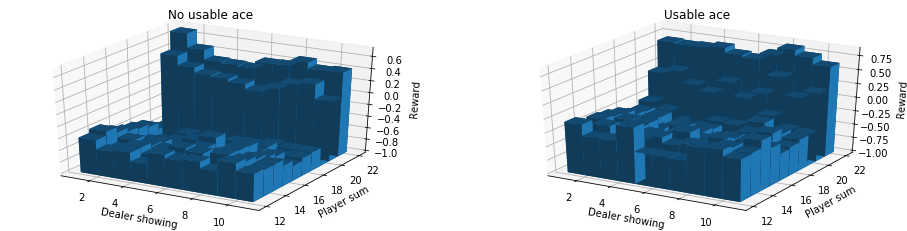

Number of iterations = 500000


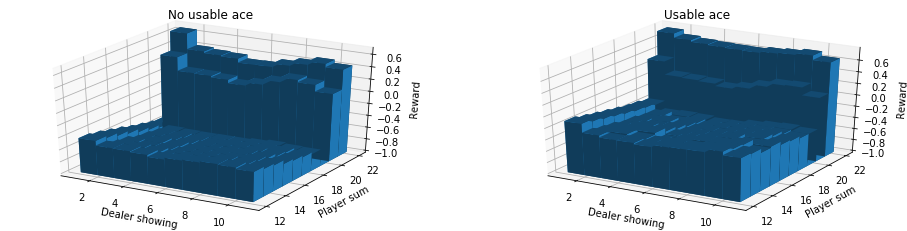

In [3]:
blackjack = Blackjack()
print("Number of iterations = 10000")
blackjack.monte_carlo_policy_eval(iters = 10000)
print("Number of iterations = 500000")
blackjack.monte_carlo_policy_eval(iters = 500000)

Number of iterations = 500000


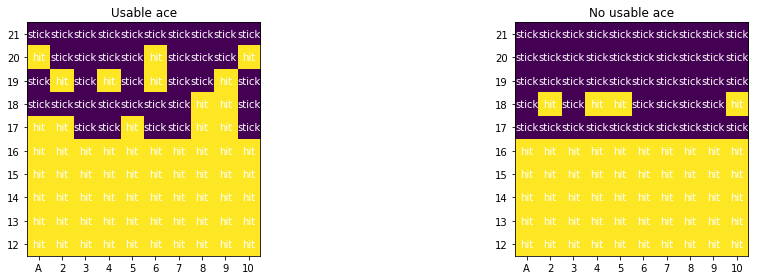

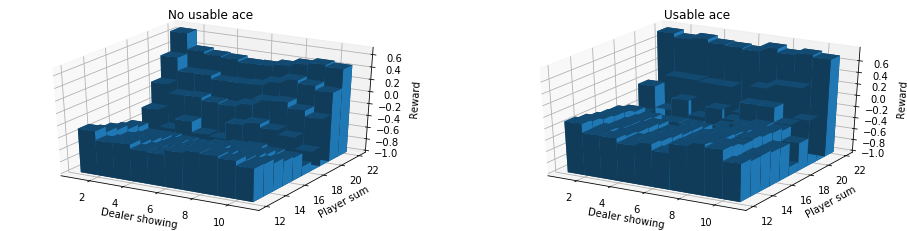

In [4]:
print("Number of iterations = 500000")
blackjack.monte_carlo_ES(iters = 500000)

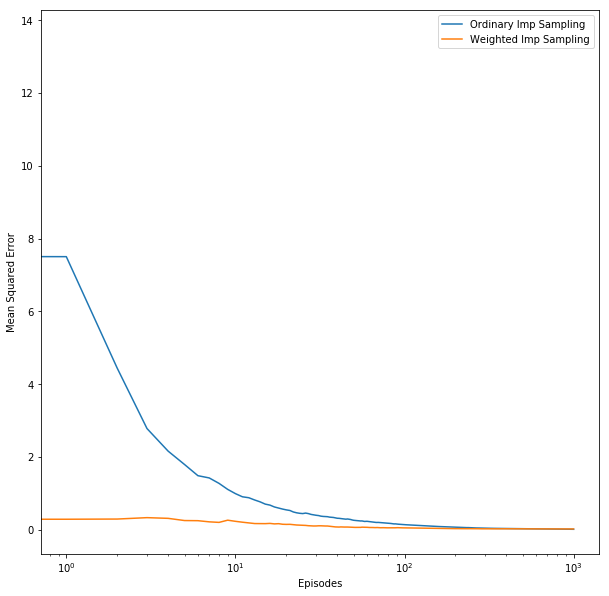

In [5]:
mse1=blackjack.monte_carlo_OIS(1000)
mse2=blackjack.monte_carlo_WIS(1000)
blackjack.plot_MSE(mse1,mse2,1000)